# Geemap Workflow for Earth Engine Classified Images with Locally Tuned and Trained Classifiers

## This Jupyter Notebook describes a geospatial workflow using geemap and an adapted LandTrendr JavaScript module to create classified images in Google Earth Engine. 
## The workflow involves using locally tuned, trained, and saved classifiers, and the geemap ml module to upload and use the classifiers for image classification. 
## The classified images are uploaded as assets for later analysis.

### The notebook demonstrates step-by-step how to:

- Set up the Python environment and authenticate with Google Earth Engine
- Load and visualize satellite image collections using geemap
- Adapt and run a LandTrendr JavaScript module in Google Earth Engine to create time-series data
- Train and locally tune a machine learning classifier using geemap
- Save the trained classifier locally and upload it to Google Earth Engine
- Apply the trained classifier to the LandTrendr time-series data to generate classified images
- Upload the classified images to Google Earth Engine as assets for further analysis

This workflow provides a powerful and flexible tool for processing and analyzing large geospatial datasets, making it useful for a wide range of applications such as land cover and land use change detection, urban planning, and natural resource management.

In [1]:
import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

today = dt.today()

# ee.Authenticate()

geemap.ee_initialize()

### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available

In [2]:
p = '..'

version = 'Version_3_20230303'

l_BE = pd.read_excel(f"{p}\Inputs\Version_3_20230303\BE.xlsx").catchment.tolist()
l_FR = pd.read_excel(f"{p}\Inputs\Version_3_20230303\FR.xlsx").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter for a space and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i

ls = ['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho',
                  'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]',
                  'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville',
                  'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville', 
                  'La Sormonne Belval', 'Le Loison Han-lés-Juvigny', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Sainte-Marie']

names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments passed for classification:\n \n{names}')

27 catchments passed for classification:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville', 'La Sormonne Belval', 'Le Loison Han-lés-Juvigny', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Sainte-Marie']



### Load the JS Module

The custom JS module takes the difficult javascript functions that do not translate well to python, and makes them callable in the notebook environment. 

Current version 6 improves the classifier by using a weighted training strategy.

This custom module borrows some functions from the LandTrendr module developed by Justin Braaten (Google) which is classified under an apache license i.e. free for use). The adaptation begins from landTrendr version 0.2 which incorporated Landsat Collection 2, removing the need for regression coefficients between sensors developed by roy et. al.

In [3]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v7.js')

# ltgee.availability  #all functions within the javascript module


IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the aut/or: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 08/03/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)


## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository


In [4]:
asset_dir = 'projects/mohanrahan/assets'

catchment_asset = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW' #currently using the WFLOW derived upstream area polygons as a feature collection on GEE asset directory

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

startYear = 1984

endYear = 2022

startDay = '06-20'

endDay = '08-31'

maskThese = ['cloud', 'shadow', 'snow',]

bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 

# Defining Functions

In [5]:
table = ee.FeatureCollection(f"{asset_dir}/{catchment_asset}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':crs,
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

df1 = down.loc[~down['station_re'].isin(names)]
#df1 = down.loc[down['station_re'].isin(names)]

print(f'The length of the dataframe generated from the EE asset {len(df1)}')

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]

The length of the dataframe generated from the EE asset 23


,pixel_area,area_km2,station_Y_,wflowID,station_X_,station_re,station_na
system_index,,,,,,,
00000000000000000026,2359.503895,2351.084147,51.208333,NaN,5.985833,,
00000000000000000028,1606.482315,1600.527467,51.716667,NaN,5.960833,,
00000000000000000009,1390.808354,1385.900191,50.850000,16.0,5.694167,Maastricht (Borgharen dorp),Maastricht (Borgharen dorp)
00000000000000000031,1178.360525,1174.069804,51.758333,NaN,5.810833,,
00000000000000000006,1070.589933,1066.867075,50.483333,11.0,5.635833,Martinrive,Martinrive
00000000000000000005,907.765987,904.651921,50.441667,10.0,5.535833,Tabreux,Tabreux
00000000000000000007,686.849390,684.428931,50.583333,12.0,5.652500,Chaudfontaine Pisc,Chaudfontaine Pisc
00000000000000000019,599.673677,597.633502,50.208333,801.0,4.960833,Gendron,Gendron
0000000000000000002b,394.114867,392.673496,51.258333,NaN,5.985833,,


pixel_area    49.352563
area_km2      49.167337
station_Y_        51.55
wflowID             NaN
station_X_       6.0525
station_re             
station_na             
Name: 0000000000000000002e, dtype: object

In [6]:
len1 = len(df1.station_re.values)
len2 = len(names)

if len1 > len2:
    print(f'catchment{ set(df1.station_re.values).symmetric_difference(names)} is/are missing from the catchment sets')
elif len2 >len1:
    print(f'catchment{ set(df1.station_re.values).symmetric_difference(names)} is/are missing from the EE asset')
else:
    print('The number of catchments with Hydroclimatic indices calculated match the length filtered EE asset\nThere seems to be no mismatch\nContinue... ')
    
aoi = Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names)))
naoi = Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names)).Not())

Map = geemap.Map()
Map.setOptions('TERRAIN')
Map.addLayer(aoi, {'color': 'green'}, 'green: Included')
Map.addLayer(naoi, {'color':'red'}, 'red: Not Included')
Map.centerObject(Filtered_Sorted, 7)


Map

catchment{'', 'Maastricht (Borgharen dorp)', 'La Meuse Saint-Mihiel', 'Martinrive', 'Hastiere', 'Yvoir', 'Huccorgne', 'La Meuse Stenay', 'Salzinnes', 'La Crusnes Pierrepont', 'Gendron', 'Sainte-Marie', 'Wiheries', 'Daverdisse', 'Membre Pont', 'La Meuse Goncourt', 'Mabompre', 'Warnant', 'La Vence la Francheville', 'Ortho', 'Tabreux', 'La Bar Cheveuges', 'La Chiers Carignan', 'Modave', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Loison Han-lés-Juvigny', 'Treignes', 'La Chiers Longlaville', 'Chooz', 'Straimont', 'Amay', 'Chaudfontaine Pisc', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Sormonne Belval', 'Le Ton Écouviez', 'Jemelle'} is/are missing from the EE asset


Map(center=[50.15762767624681, 5.442982293509325], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [7]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)


def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds):
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i, yc, classified, trainingClassImage, ms, classImageYear, name, accuracy, pixArea):

    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pixArea
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted


## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [8]:
classifier_used = 'Meuse_HC_tuned'

c_1990 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_1990')
c_2000 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2000')
c_2006 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2006')
c_2012 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2012')
c_2018 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2018')

In [ ]:
classLoopParams = {'dataset':'CORINE',    #training dataset, no other than corine currently supported
               'trainingClassLevel':1, #classLevel determines the level of corine class simplification
               'customClassLevels':None,   #can provide some custom levels, not fully tested
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
                'distribution':'weighted',  # can be weighted or balanced, weighting is done be area proportion
               'weighting':[0.1229968497019534,
                            0.5409423201468542,
                            0.32752477729507024,
                            0.0023704561188078047,
                            0.0061655967373145425],  # weighting based on area, percentages are passed , dictionaries do not pass to javascript code as well as lists
               'year_classified': [2004],   # classification year is , for classifiers saved, the same as the years available in the training dataset
              }

output_folder = f'../Outputs/{dataset}/RF_classification/{classifier_used}'

if not os.path.exists(output_folder):
    print(f'{output_folder} created')
    os.makedirs(output_folder)



In [ ]:
t0 = dt.today()


print(f'begin loop: {t0}')

aoi = naoi


for i, ind in enumerate(['HC_catchments']):

    pix_area = df1.pixel_area.sum()
    
    name = 'outer_catchments'
    
    t1 = dt.today()
    
    print(f'{name}, \nSurface Reflectance Processing ...\n')
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, [''])
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - Then we use the trained classifier to classify any images of interest
        
        '''
        
        for j, yc in enumerate(classLoopParams['year_classified']):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            if yc >= 1984 and yc < 1999:
                classifier = c_1990
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classifier = c_2000
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classifier = c_2006
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classifier = c_2012
                classImageYear = 2012

            elif yc >= 2015:
                classifier = c_2018
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
            
            print('begin', {yc})
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first().clip(aoi)
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), 
                                                           classLoopParams['dataset'], 
                                                           classLoopParams['trainingClassLevel'], 
                                                           aoi)
            
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(clipped, 
                                                   aoi)
            
            
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, 
                                  imageToClassify, 
                                  classLoopParams['numClasses'], #set at 5 usually
                                  classLoopParams['split'],      #set at 70/30
                                  classLoopParams['tileScale'], 
                                  aoi, 
                                  classLoopParams['distribution'], #either balanced or weighted
                                  classLoopParams['weighting'])
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            print('classifying:', yc)
                        
            #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            print('classified')
            
            #assess the accuracy using the testing points, see where the confusion occurs
            error_matrix = testing.classify(classifier).errorMatrix('landcover', 'classification')
            
            #pull the error matrix for classification asessment later
            print('pulling error matrix:')
            em = np.array(error_matrix.getInfo())[1:,1:]
            print(em)
        
            np.save(f'{output_folder}/{ind}_{yc}_validationMatrix.npy', arr=em, allow_pickle=True)
            
            accuracy = error_matrix.accuracy().getInfo()
            
            print(f'overall accuracy: {accuracy}')
            
            print('sendingTask...')
            
            task = ee.batch.Export.image.toAsset(**{
            'image': classified, 
            'description':f'{dataset}_{name}_{yc}', 
            #'folder':f'{asset_dir}/CATAPUCII_{dataset}_LandClasses/', #TODO - user input
            'assetId':f'projects/mohanrahan/assets/CATAPUCII_Meuse_LandClasses/{dataset}_{yc}_{name}',
            'scale': 30,
            'region': aoi.geometry(),#getInfo()['coordinates'],
                'crs':crs,
            })
            
            
            task.start()
            
            print('task sent')
            
            np.save(f'{output_folder}/{ind}_{yc}__{name}_accuracy.npy', arr=np.array([accuracy]))
            
            print(f'{yc} classified using: {classImageYear} ...  \naccuracy: {accuracy:.3f}')


    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    if ind == sys_index[0]:
        break



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(classified, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']})
Map

In [ ]:
classArea_df1.keys()

In [ ]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']

rdx = classArea_df1.reset_index().fillna(0)
for i in range(6):
    print(class_name[i], np.mean(rdx.area_CORINE.iloc[:,i]/rdx.catchment.area))

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

rdx

In [ ]:
def compute_rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Computes the root mean squared error (RMSE) of two pandas Series.
    """
    # Ensure both Series have the same length
    assert len(y_true) == len(y_pred), "Input Series must have the same length"
    
    # Compute the difference between the true and predicted values
    error = y_true - y_pred
    
    # Compute the mean squared error (MSE)
    mse = np.mean(error**2)
    
    # Compute the RMSE
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:

rdx = classArea_df1.reset_index().fillna(0)
# rdx.area_RF.iloc[:, 5] = rdx.area_RF.iloc[:,0:4].sum(axis=1) - rdx.catchment.area
rdx[('area_RF', 'masked')] = rdx.area_RF.iloc[:,0:5].sum(axis=1) - rdx.catchment.area

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

print('Fixed Mask', np.mean(rdx.area_RF.masked/rdx.catchment.area))


grouped = rdx.groupby('image_date').sum()
grouped

grouped = rdx.groupby('image_date').sum()

colors = ['#E6004D', 'orange', '#80FF00', '#A6A6FF', '#00CCF2', 'black']

fig, axes = plt.subplots(3,2, figsize = (18,15))

tit = plt.suptitle('Chooz Classification Model', y=0.94, size=18)

for i in range(6):
    if i == 0:
        col=0
        row=0
    elif i==1:
        col=1
        row=0
    elif i==2:
        col=0
        row=1
    elif i==3:
        col=1
        row=1
    elif i==4:
        col=0
        row=2
    
    if i<5:
        y_pred = grouped.area_RF.iloc[:,i]/grouped.catchment.area
    
        y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area

        rmse = compute_rmse(y_true, y_pred)
        ax = axes[row, col]
        ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
        ax.plot(y_pred,linestyle='dashed', c=colors[i], label=f'{class_name[i]} modelled')
        ax.plot(y_true, c=colors[i], label=f'{class_name[i]} corine')
        ax.set_ylabel('Fraction of basin')
        plt.legend()
    
    if i==5:
        col=1
        row=2
        ax = axes[row, col]
        y_pred = grouped.area_RF.masked.abs()/grouped.catchment.area
    
        y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area

        rmse = compute_rmse(y_true, y_pred)
        ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
        ax.plot(y_pred, linestyle='dashed', c=colors[i], label= f'')
        ax.plot(y_true/grouped.catchment.area, c=colors[i])
        ax.set_ylabel('Fraction of basin')



In [73]:
class_search = pd.read_excel('../Outputs/meuse/RF_classification/preTuning/classifier_search.xlsx', header=[0,1], index_col=0, parse_dates=True)
class_search.keys()

MultiIndex([('area_CORINE',                   '1'),
            ('area_CORINE',                   '2'),
            ('area_CORINE',                   '3'),
            ('area_CORINE',                   '4'),
            ('area_CORINE',                   '5'),
            (    'area_RF',                   '1'),
            (    'area_RF',                   '2'),
            (    'area_RF',                   '3'),
            (    'area_RF',                   '4'),
            (    'area_RF',                   '5'),
            (   'training',        'year_trained'),
            ('area_CORINE',                   '6'),
            (  'catchment',                'area'),
            (    'area_RF',                   '6'),
            (  'catchment',               'name '),
            (    'testing',            'accuracy'),
            (        'ind', 'Unnamed: 17_level_1')],
           names=[None, 'class'])

In [74]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    class_search.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [75]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
acc_post = [0.945, 0.957, 0.955, 0.960, 0.956]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/preTuning/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

area_CORINE                                               \
class                         1           2           3         4          5   
image_date                                                                     
2018-08-31 22:00:00  108.696124  600.561064  859.017972  1.373331  19.890701   
2018-08-31 22:00:00   35.427795  218.596639  292.070370  0.907128   1.304537   
2018-08-31 22:00:00    6.957725  263.506508  130.410072  2.640857   2.294175   

                        area_RF                                                \
class                         1           2           3          4          5   
image_date                                                                      
2018-08-31 22:00:00  166.729849  494.983704  788.659230  77.415980  57.183356   
2018-08-31 22:00:00   73.821864  172.814694  255.115498  38.918854   5.460617   
2018-08-31 22:00:00   59.673091  185.001977  125.209307  26.706760   7.395682   

                        training area_CORINE    catchment     area_RF  \
class               year_trained           6         area           6   
image_date                                                              
2018-08-31 22:00:00         2018           0  1589.539192  171.296922   
2018-08-31 22:00:00         2018           0   548.306470   75.996808   
2018-08-31 22:00:00         2018           0   405.809337   61.495611   

                            catchment   testing                 ind  
class                           name   accuracy Unnamed: 17_level_1  
image_date                                                           
2018-08-31 22:00:00             Chooz  0.796321                 0_4  
2018-08-31 22:00:00          Treignes  0.784553                 6_4  
2018-08-31 22:00:00  La Bar Cheveuges  0.774127                 8_4

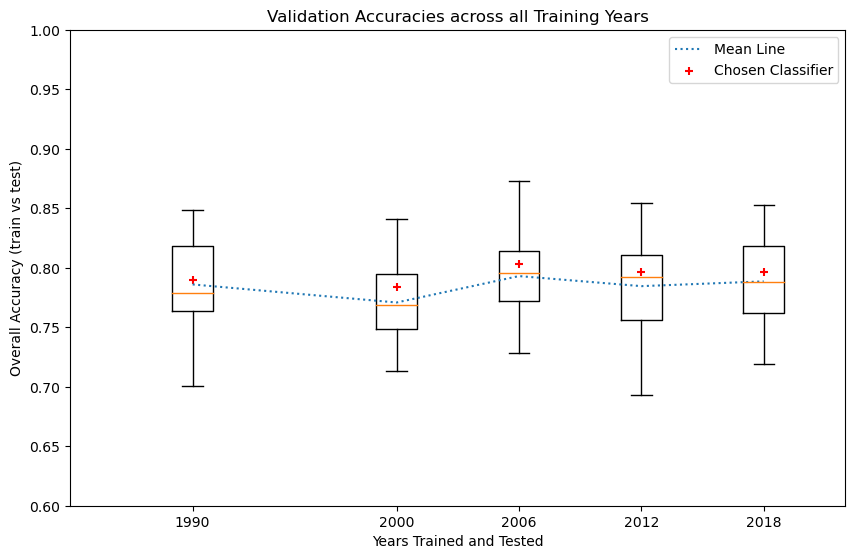

In [83]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = class_search.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')

ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

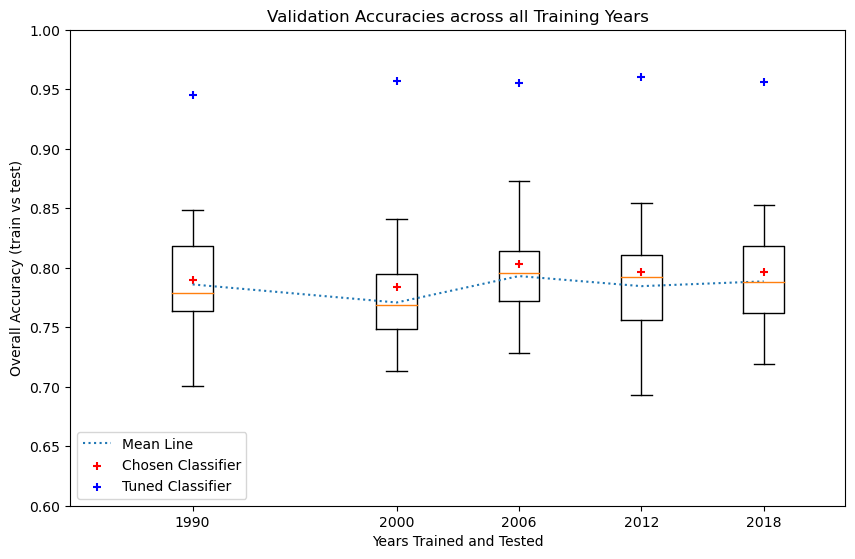

In [86]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.scatter(year_classified, acc_post, marker='+', c='b', label='Tuned Classifier')
ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

In [ ]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map